In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg
%matplotlib inline

In [2]:
data = pd.read_csv('../Data_Files/Stalker.dat', sep='\t')
data.head()

,group,stalk1,stalk2
0,1,47,11
1,1,50,18
2,1,51,34
3,1,52,40
4,1,53,50


In [3]:
data.groupby('group').describe()

stalk1                                                 stalk2         \
       count   mean        std   min   25%   50%   75%   max  count   mean   
group                                                                        
1       25.0  64.84  10.679732  47.0  57.0  64.0  73.0  85.0   25.0  54.96   
2       25.0  65.60  10.835897  46.0  58.0  65.0  72.0  89.0   25.0  61.84   

                                                
             std   min   25%   50%   75%   max  
group                                           
1      16.331156  11.0  52.0  60.0  63.0  80.0  
2       9.410455  46.0  56.0  62.0  64.0  79.0

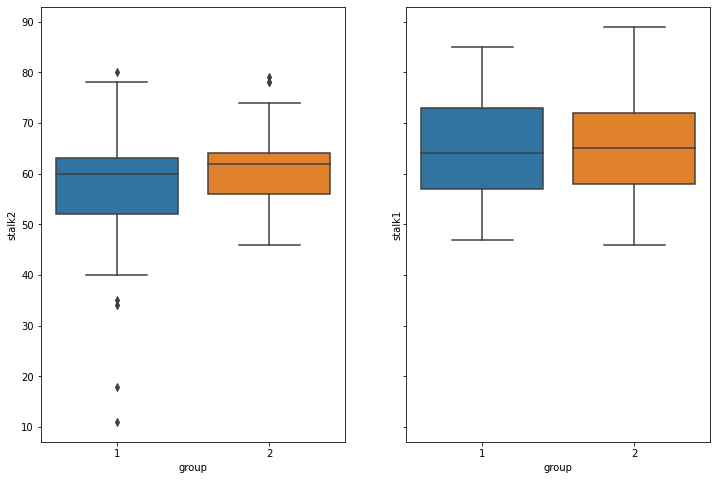

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(12,8))
_ = sns.boxplot(x='group', y='stalk2', data=data, ax=ax1)
_ = sns.boxplot(x='group', y='stalk1', data=data, ax=ax2)

In [6]:
data_1 = data[data['group']==1]
data_2 = data[data['group']==2]

In [7]:
st.levene(data_1['stalk2'], data_2['stalk2'])

LeveneResult(statistic=1.9126249183149782, pvalue=0.17307186493263124)

In [8]:
m01 = smf.ols('stalk1~C(group)', data=data).fit()
anova_table = sm.stats.anova_lm(m01)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,7.22,7.220000,0.062383,0.803834
Residual,48.0,5555.36,115.736667,NaN,NaN


#### # It shows the results of such an ANOVA. The main effect of dose is not significant, F(1, 48) = .062, p = .80, which shows that the average level of stalk1 was roughly the same in the 2 groups. In other words, the means for stalk1 are not significantly different in the groups 1 and 2. This result means that it is appropriate to use stalk1 as a covariate in the analysis

In [9]:
m02 = smf.ols('stalk2~C(group)+stalk1', data=data).fit()
m02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 stalk2   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     28.61
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           7.45e-09
Time:                        18:03:06   Log-Likelihood:                -181.19
No. Observations:                  50   AIC:                             368.4
Df Residuals:                      47   BIC:                             374.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.8406      8.349     -0.340      0.735     -19.637      13.955
C(group)[T.2]     6.2025      2.647      2.343      0.023       0.877      11.528
stalk1            0.8914      0.125      7.104      0.000       0.639       1.144
==============================================================================
Omnibus:                       23.963   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.952
Skew:                          -1.237   Prob(JB):                     9.59e-14
Kurtosis:                       7.760   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
anova_table2 = sm.stats.anova_lm(m02, typ=2)
anova_table2

,sum_sq,df,F,PR(>F)
C(group),480.264911,1.0,5.489780,2.341162e-02
stalk1,4414.597977,1.0,50.462094,5.692017e-09
Residual,4111.722023,47.0,NaN,NaN


### y = -2.8406 + 0.8914 stalk1 + 6.2025 t2

In [11]:
y_1 = -2.8406+0.8914*data['stalk1'].mean()
y_1

55.296507999999996

In [12]:
y_2 = -2.8406+0.8914*data['stalk1'].mean()+6.2025*1
y_2

61.499007999999996

In [14]:
prediction = pd.DataFrame(m02.fittedvalues)
prediction.columns = ['predicted'] 
prediction['standarized_prediction']  = (prediction['predicted']-prediction['predicted'].mean())/prediction['predicted'].std()
prediction.head()

,predicted,standarized_prediction
0,39.056807,-1.913677
1,41.731111,-1.649101
2,42.622545,-1.560909
3,43.513980,-1.472717
4,44.405415,-1.384524


In [15]:
import statsmodels.stats.outliers_influence as sms

In [17]:
summary_frame = sms.OLSInfluence(m02).summary_frame()
summary_frame = pd.merge(summary_frame, prediction, how = 'inner', left_index = True, right_index = True)

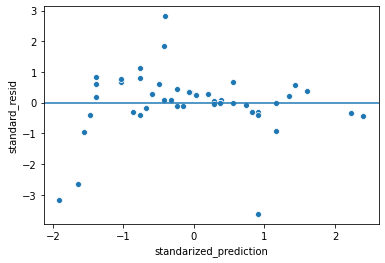

In [18]:
_ = sns.scatterplot(y = 'standard_resid', x='standarized_prediction', data = summary_frame)
_ = plt.axhline(y=0)

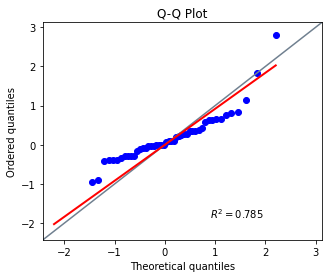

In [19]:
_ = pg.qqplot(summary_frame['standard_resid'], confidence=False)

In [20]:
m03 = smf.ols('stalk2~C(group)', data=data).fit()
m03.summary()
anovaTable = sm.stats.anova_lm(m03)
anovaTable

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,591.68,591.680000,3.330938,0.074214
Residual,48.0,8526.32,177.631667,NaN,NaN


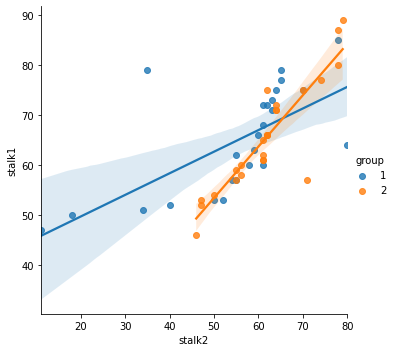

In [21]:
_ = sns.lmplot(x='stalk2', y='stalk1', hue='group', data=data)       # groupwise effect

In [22]:
hoRS= smf.ols('stalk2~C(group)*stalk1', data=data).fit()
anova_hoRS = sm.stats.anova_lm(hoRS, typ=3)
anova_hoRS

,sum_sq,df,F,PR(>F)
Intercept,71.327015,1.0,0.813266,3.718542e-01
C(group),148.329042,1.0,1.691239,1.999157e-01
stalk1,2798.659389,1.0,31.910141,9.695819e-07
C(group):stalk1,77.320234,1.0,0.881601,3.526680e-01
Residual,4034.401789,46.0,NaN,NaN


#### # The output shows that the interaction between group and stalk1 (the covariate) is not significant, which means that we can assume homogeneity of regression slopes.

In [23]:
anova_table2

,sum_sq,df,F,PR(>F)
C(group),480.264911,1.0,5.489780,2.341162e-02
stalk1,4414.597977,1.0,50.462094,5.692017e-09
Residual,4111.722023,47.0,NaN,NaN


In [24]:
eta_squared_group = 480.26/(480.26+4111.72)
eta_squared_cov = 4414.6/(4414.6+4111.72)

In [25]:
eta_squared_group

0.10458669245075108

In [26]:
eta_squared_cov

0.5177614727103839